In [1]:
import xarray as xr

In [2]:
core_profiles = xr.open_dataset(
    "data/core_profiles.h5",
    engine="h5netcdf",
    group="core_profiles",
)

ValueError: variable '/core_profiles/global_quantities&energy_diamagnetic' has no dimension scale associated with axis 0. 
Use phony_dims='sort' for sorted naming or phony_dims='access' for per access naming.

From https://github.com/h5netcdf/h5netcdf?tab=readme-ov-file#datasets-with-missing-dimension-scales:

Datasets with missing dimension scales

By default [2] h5netcdf raises a ValueError if variables with no dimension scale associated with one of their axes are accessed. You can set phony_dims='sort' when opening a file to let h5netcdf invent phony dimensions according to netCDF behaviour.

```python
# mimic netCDF-behaviour for non-netcdf files
f = h5netcdf.File('mydata.h5', mode='r', phony_dims='sort')
...
```

Note, that this iterates once over the whole group-hierarchy. This has affects on performance in case you rely on laziness of group access. You can set phony_dims='access' instead to defer phony dimension creation to group access time. The created phony dimension naming will differ from netCDF behaviour.

```python
f = h5netcdf.File('mydata.h5', mode='r', phony_dims='access')
...
```

Footnotes
[2]	Keyword default setting phony_dims=None for backwards compatibility.

In [3]:
core_profiles = xr.open_dataset(
    "data/core_profiles.h5",
    engine="h5netcdf",
    group="core_profiles",
    phony_dims="access",
    # phony_dims="sort",
)

In [4]:
core_profiles

<xarray.Dataset> Size: 29kB
Dimensions:                                           (phony_dim_0: 1,
                                                       phony_dim_2: 200,
                                                       phony_dim_1: 1,
                                                       phony_dim_3: 2)
Dimensions without coordinates: phony_dim_0, phony_dim_2, phony_dim_1,
                                phony_dim_3
Data variables: (12/52)
    code&commit                                       <U7 28B ...
    code&name                                         <U19 76B ...
    code&repository                                   <U7 28B ...
    code&version                                      <U7 28B ...
    global_quantities&energy_diamagnetic              (phony_dim_0) float64 8B ...
    global_quantities&ip                              (phony_dim_0) float64 8B ...
    ...                                                ...
    profiles_1d[]&q_SHAPE                             (phony_dim_0, phony_dim_1) int32 4B ...
    profiles_1d[]&t_i_average                         (phony_dim_0, phony_dim_2) float64 2kB ...
    profiles_1d[]&t_i_average_SHAPE                   (phony_dim_0, phony_dim_1) int32 4B ...
    profiles_1d[]&zeff                                (phony_dim_0, phony_dim_2) float64 2kB ...
    profiles_1d[]&zeff_SHAPE                          (phony_dim_0, phony_dim_1) int32 4B ...
    time                                              (phony_dim_0) float64 8B ...

In [5]:
core_profiles = (
    core_profiles.drop_dims("phony_dim_1")
    .swap_dims(
        {
            "phony_dim_0": "time",
            "phony_dim_2": "rho_tor_norm",
            "phony_dim_3": "ion",
        }
    )
    .set_coords(
        [
            "profiles_1d[]&grid&rho_tor_norm",
            "profiles_1d[]&ion[]&label",
        ]
    )
    .rename_vars(
        {
            "profiles_1d[]&grid&rho_tor_norm": "rho_tor_norm",
            "profiles_1d[]&ion[]&label": "ion",
        }
    )
)

In [6]:
core_profiles

<xarray.Dataset> Size: 29kB
Dimensions:                                           (time: 1,
                                                       rho_tor_norm: 200, ion: 2)
Coordinates:
    rho_tor_norm                                      (time, rho_tor_norm) float64 2kB ...
    ion                                               (time, ion) <U3 24B ...
  * time                                              (time) float64 8B 0.3003
Data variables: (12/30)
    code&commit                                       <U7 28B ...
    code&name                                         <U19 76B ...
    code&repository                                   <U7 28B ...
    code&version                                      <U7 28B ...
    global_quantities&energy_diamagnetic              (time) float64 8B ...
    global_quantities&ip                              (time) float64 8B ...
    ...                                                ...
    profiles_1d[]&ion[]&pressure_thermal              (time, ion, rho_tor_norm) float64 3kB ...
    profiles_1d[]&ion[]&temperature                   (time, ion, rho_tor_norm) float64 3kB ...
    profiles_1d[]&ion[]&z_ion                         (time, ion) float64 16B ...
    profiles_1d[]&q                                   (time, rho_tor_norm) float64 2kB ...
    profiles_1d[]&t_i_average                         (time, rho_tor_norm) float64 2kB ...
    profiles_1d[]&zeff                                (time, rho_tor_norm) float64 2kB ...

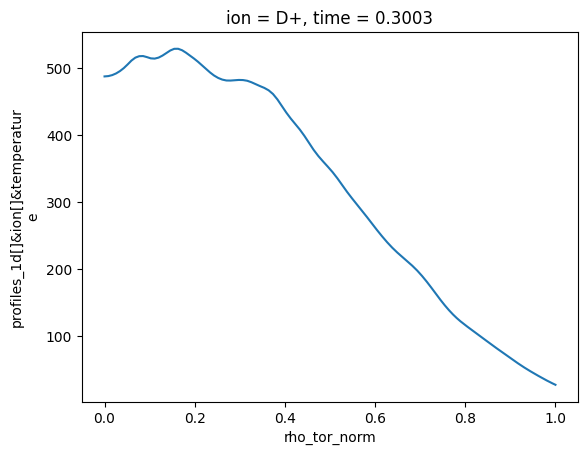

In [7]:
core_profiles["profiles_1d[]&ion[]&temperature"].isel(time=0, ion=0).plot()

Now to restructure into a zarr file.

In [9]:
with zarr.open("data/core_profiles.zarr", mode="w") as root:
    root.create_dataset("time", data=core_profiles.time.values)
    root.create_dataset("rho_tor_norm", data=core_profiles.rho_tor_norm.values)
    root.create_dataset(
        "electron_temperature",
        data=core_profiles["profiles_1d[]&electrons&temperature"].values,
    )
    root["time"].attrs["_ARRAY_DIMENSIONS"] = ["time"]
    root["rho_tor_norm"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
    root["electron_temperature"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
    root.create_group("ions")
    zarr.consolidate_metadata("data/core_profiles.zarr")

In [ ]:
# import zarr

# with zarr.open("data/core_profiles.zarr", mode="w") as root:
#     root.create_dataset("time", data=core_profiles.time.values)
#     root.create_dataset("rho_tor_norm", data=core_profiles.rho_tor_norm.values)
#     root.create_dataset(
#         "electron_temperature",
#         data=core_profiles["profiles_1d[]&electrons&temperature"].values,
#     )
#     # root.attrs["_ARRAY_DIMESIONS"] = ["time", "rho_tor_norm"]
#     root["time"].attrs["_ARRAY_DIMENSIONS"] = ["time"]
#     root["rho_tor_norm"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
#     root["electron_temperature"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
#     root.create_group("ions")
#     zarr.consolidate_metadata("data/core_profiles.zarr")

# xr.open_zarr("data/core_profiles.zarr")